In [1]:
import json
import pytz
from datetime import datetime, timezone, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from transformers import pipeline
import pandas as pd
import seaborn as sns

In [9]:
conversations_file_location = '../data/conversations.json' 
local_time_zone = 'Asia/Colombo' 
# pytz.all_timezones # uncomment to see a list of all supported timezones.

In [7]:
main_categories = [
    "Technology & Programming",
    "Data Science & Analytics",
    "Business & Finance",
    "Science & Research",
    "Education & Study Help",
    "Career & Professional Development",
    "Productivity & Self-Improvement",
    "General Knowledge & Facts",
    "Entertainment & Pop Culture",
    "Lifestyle & Personal Interests",
    "Philosophy & Society",
    "Current Events & News"
]

In [10]:
with open(conversations_file_location, 'r') as file:
    conversations = json.load(file)

In [13]:
def extract_info(data):
    create_times = []

    
    # Check if 'title' exists and extract 'title'
    if 'title' in data and data['title']:
        title = data['title']

    # Check if conversation 'create_time' exists in the main dictionary and extract 'create_time'
    if 'create_time' in data and data['create_time']:
        create_times.append(data['create_time'])
        

    # Check in mapping messages and extract 'create_time'
    if 'mapping' in data:
        for key, value in data['mapping'].items():
            if 'message' in value and value['message'] is not None:
                if 'create_time' in value['message'] and value['message']['create_time']:
                    create_times.append(value['message']['create_time'])

    return create_times,title

# Converting creat_times to datetime objects
def convert_to_local_time(all_create_times):
    converted_create_times = []
    for conversation in all_create_times:
        for create_time in conversation:
            create_time_converted = datetime.fromtimestamp(create_time, tz=timezone.utc).astimezone(pytz.timezone(local_time_zone))
            converted_create_times.append(create_time_converted)
    return converted_create_times

# Generating the heatmap
def create_year_heatmap(convo_times, year):
    # Extracting only the dates from the timestamps for the corresponding year
    just_dates = [convo.date() for convo in convo_times if convo.year == year]
    
    # Count how many messages were sent on each day
    date_counts = Counter(just_dates)

    # Defining the start and end dates for the entire year
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()
    total_days = (end_date - start_date).days + 1  

    # Generating a complete list of dates for the year
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]
    
    data = []
    for date in date_range:
        # Calculate the corresponding week index 
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()  # Get the day of the week 
        count = date_counts.get(date, 0)  # Get the message count for that day and set default to 0
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1  

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')  # Ensure the grid cells are square

    # Determining the day with the highest message count for the title
    if date_counts:
        max_count_date = max(date_counts, key=date_counts.get)  # Date with the highest message count
        max_count = date_counts[max_count_date]  # Maximum message count on a single day
    else:
        max_count_date, max_count = None, 0

    # Calculating the 90th percentile count to normalize the color intensity in the heatmap
    p90_count = np.percentile(list(date_counts.values()), 90) if date_counts else 1

    # Drawing the heatmap grid
    for week, day_of_week, count in data:

        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    # Identify the first day of each month to label the x-axis
    month_starts = [start_date + timedelta(days=i) for i in range(total_days) 
                    if (start_date + timedelta(days=i)).day == 1]
    
    # Add month labels along the x-axis
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    
    plt.title(
        f'{year} Message Activity Heatmap (total={sum(date_counts.values())}).\n'
        f'Most active day: {max_count_date} with {max_count} messages.',
        fontsize=16
    )

    plt.xticks([])
    plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Invert y-axis so Monday appears at the top
    plt.gca().invert_yaxis()
    
    plt.show()

    
def categorize_conversations(categories,conversation_titles):
    category_results = []
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=0)

    for title in conversation_titles:
        result = classifier(title, categories)
        best_category = result['labels'][0]  # The category with the highest score
        category_results.append(best_category)
        
    titles_with_categories = pd.DataFrame({
    'Title': conversation_titles,
    'Best Category': category_results
    })
    
    category_counts = titles_with_categories['Best Category'].value_counts()
    
    # Geting the counts of each category
    category_counts = titles_with_categories['Best Category'].value_counts().reset_index()
    category_counts.columns = ['Category', 'Count']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Category', data=category_counts, palette='Blues')

    plt.xlabel('Conversation Count')
    plt.ylabel('Category')
    plt.title('No of Conversation under each Category')

    plt.tight_layout()
    plt.show()



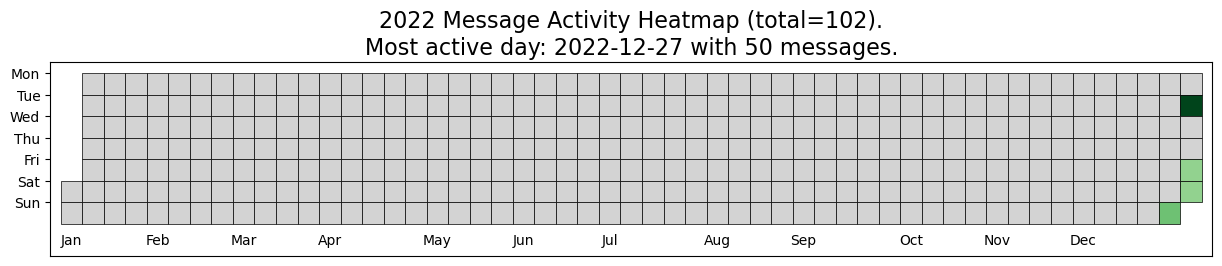

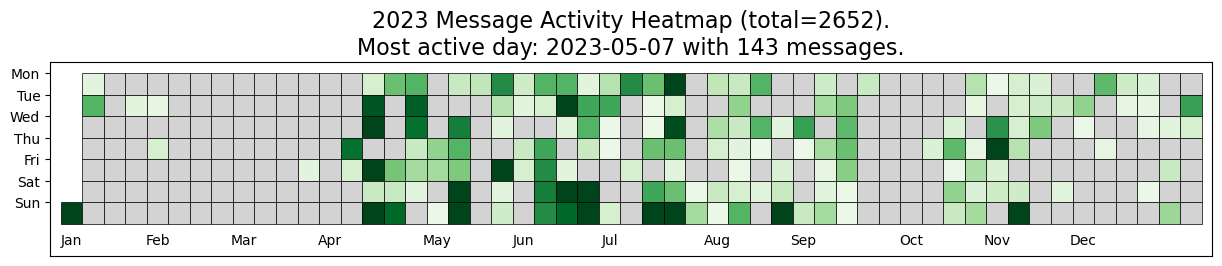

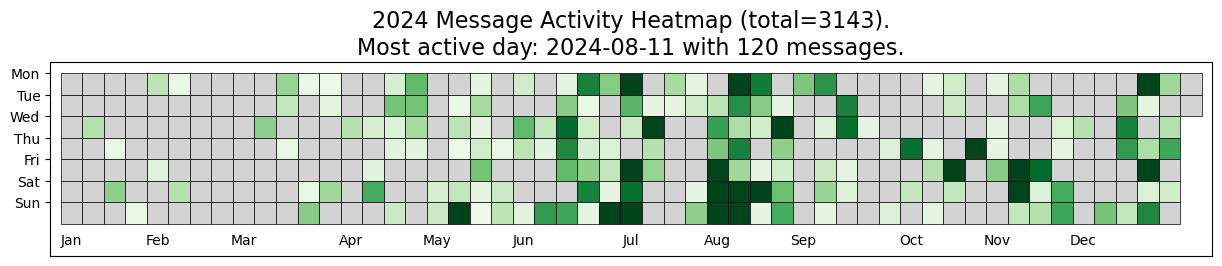

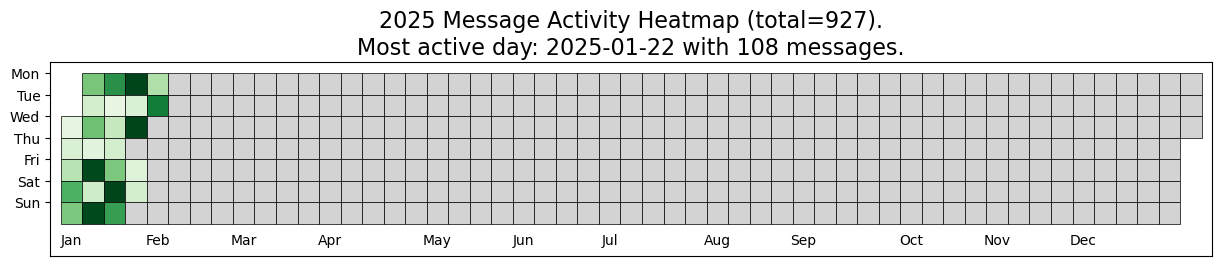

Device set to use cpu
C:\Users\hcham\AppData\Local\Temp\ipykernel_7004\814402251.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Category', data=category_counts, palette='Blues')


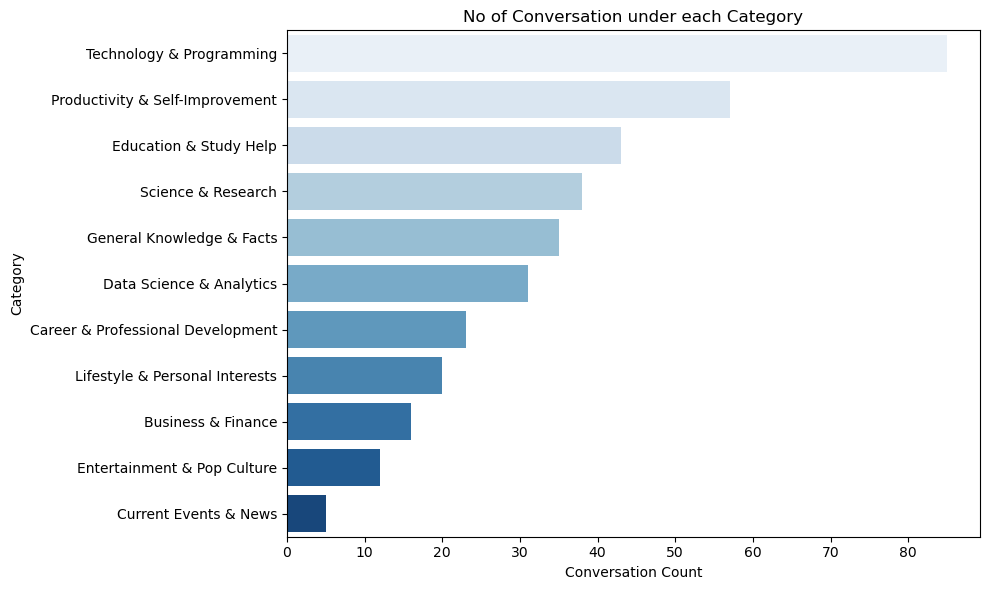

In [14]:
conversation_titles = []
all_create_times = []

for conv in conversations:
    create_times,title = extract_info(conv)
    conversation_titles.append(title)
    all_create_times.append(create_times)
    
converted_create_times = convert_to_local_time(all_create_times)

years = [2022,2023,2024,2025]

for year in years:
    create_year_heatmap(converted_create_times,year)

categorize_conversations(main_categories,conversation_titles)